###                                      **Sentiment Analysis**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
STOPWORDS = set(stopwords.words('english'))
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
df=pd.read_csv('/content/Reviews.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,61946.000000,61946.000000,61946.000000,61946.000000,6.194600e+04
mean,30973.500000,1.632955,2.112081,4.152375,1.295148e+09
std,17882.414225,5.442560,6.123128,1.328556,4.744299e+07
min,1.000000,0.000000,0.000000,1.000000,9.617184e+08
25%,15487.250000,0.000000,0.000000,4.000000,1.269907e+09
50%,30973.500000,0.000000,1.000000,5.000000,1.309046e+09
75%,46459.750000,2.000000,2.000000,5.000000,1.331078e+09
max,61946.000000,398.000000,401.000000,5.000000,1.351210e+09


In [49]:
# @title Default title text
df[['Text','onverted_text']].head(20)
df[['Text','onverted_text','Negative Score', 'Neutral Score', 'Positive Score', 'Compound Score']].to_csv('Reviews_Changed.csv')

In [5]:
import plotly.express as px

score_counts = df.groupby('Score').size().reset_index(name='Count')

fig = px.bar(score_counts, x='Score', y='Count',
             title='Count of Reviews under each score',
             labels={'Score': 'Score', 'Count': 'Number of Reviews'})
fig.show()




## Data Preprocessing

In [4]:
df.dropna(inplace=True)

Case Conversion

In [6]:
def convert_lower(df,text):
  df['onverted_text']=df[text].str.lower()
  return df

Remove Numerical Values

In [7]:
def remove_numerics(text):
    num = re.compile(r'[0-9]')
    return num.sub(r'', text)

Remove URLs

In [8]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

Remove Stopwords

In [9]:
def remove_stopwords(text):
  #print("I am here :",text)
  st=" ".join([i for i in str(text).split() if i not in STOPWORDS])
  return st

Remove Punctuations

In [10]:
def remove_punctuation(text):
  st=''.join([i for i in text if i not in string.punctuation])
  return st

Remove emojis

In [11]:
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

Remove emoticons

In [12]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(r'[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[<>]?[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8]')
    return emoticon_pattern.sub(r'', text)


Remove html tags

In [13]:
from bs4 import BeautifulSoup

def remove_html(text):
    return BeautifulSoup(text, "lxml").text

Chat word Conversion

In [14]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [15]:
chat_word_list=[]
chat_words_map_dict = {}
for i in chat_words_str.split('\n'):
  if i!='':
    cw = i.split('=')[0]
    cw_expanded = i.split('=')[1]
    chat_word_list.append(cw)
    chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_word_list)
def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

Perform Stemming

In [16]:
def stmng(para):
  tkn_para=para
  # convert Paragraph to list of sentences
  sentences = nltk.sent_tokenize(para)
  stemmer = nltk.PorterStemmer()
  # Convert Sentences to words

# Stemming
  for i in range(len(sentences)):
      words = nltk.word_tokenize(sentences[i])
      words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))]
      words = [word for word in words if word not  in string.punctuation]
      sentences[i] = ' '.join(words)
      para='.'.join(sentences)
  return para

Perform Lemmatization

In [17]:
def lemma(para):
  tkn_para=para
  # convert Paragraph to list of sentences
  sentences = nltk.sent_tokenize(para)
  lemmatizer = WordNetLemmatizer()
  # Convert Sentences to words

# Stemming
  for i in range(len(sentences)):
      words = nltk.word_tokenize(sentences[i])
      words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
      words = [word for word in words if word not  in string.punctuation]
      sentences[i] = ' '.join(words)
      para='.'.join(sentences)
  return para

## Sentiment Analysis using VADER Sentiment Scoring

In [18]:
sia = SentimentIntensityAnalyzer()
def sentiment_score(text):
  score=sia.polarity_scores(text)
  return score['neg'],score['neu'],score['pos'],score['compound']

In [19]:
df_converetd=convert_lower(df,'Text')

In [23]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(remove_numerics)

In [25]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(remove_stopwords)

In [24]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(remove_emojis)

In [23]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(remove_punctuation)

In [20]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(remove_urls)

In [21]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(remove_html)

In [22]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(remove_emoticons)

In [ ]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(stmng)

In [26]:
df_converetd['onverted_text']=df_converetd['onverted_text'].apply(lemma)

KeyboardInterrupt: 

In [47]:
# Apply sentiment_score to each row and store the results in separate columns
df_converetd[['Negative Score', 'Neutral Score', 'Positive Score', 'Compound Score']] = df_converetd['onverted_text'].apply(sentiment_score).apply(pd.Series)


Visualization of Sentiment Score against Rated Score

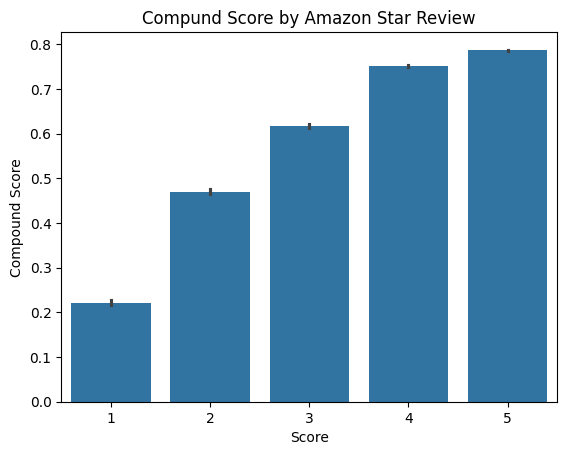

In [51]:
ax = sns.barplot(data=df_converetd, x='Score', y='Compound Score')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

In [1]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df_converetd, x='Score', y='Positive Score', ax=axs[0])
sns.barplot(data=df_converetd, x='Score', y='Neutral Score', ax=axs[1])
sns.barplot(data=df_converetd, x='Score', y='Negative Score', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined